# Import libraries

In [303]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from utils import image_to_pixels, preprocess_pixels
from PIL import Image 

# Read Sudoku Image

First we will select any random image and it doesn't matter which one it is because it is only to write code for contour detection of the Sudoku grid. Might as well just go with the first image.

In [304]:
# For testing
rel_path = './images/sudoku-box/'
images_list = os.listdir(rel_path)
sudoku_box_file = images_list[0]
file_path = rel_path + sudoku_box_file
file_path

# # Real Sudoku Grid
# file_path = './images/toy/2022-us-sudoku-grand-prix-round.png'


'./images/sudoku-box/_2_1351224 2.jpeg'

# Preprocess Image to find Contours

First we will plot the image to see how the original Sudoku image looks like.

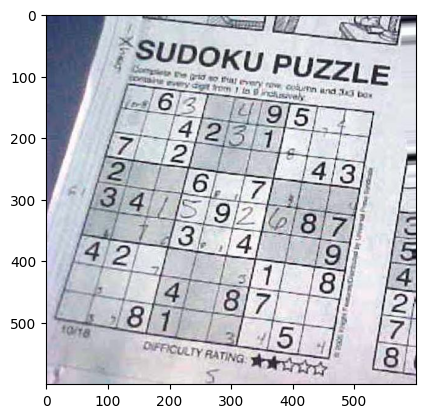

In [305]:
image = cv2.imread(file_path)
plt.imshow(image)
plt.show()

To preprocess the image to get the threshold we will make a utils function to find contours we will do the following steps:  
1. convert to grayscale.
2. resize the image.
3. add a blur.

In [306]:
def preprocess_grid(image:np.array) -> np.array:
    resize_dim = (450,450)
    height = resize_dim[0]
    width = resize_dim[1]
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (height,width))
    blurred_image = cv2.GaussianBlur(resized_image, (5,5), cv2.BORDER_DEFAULT)
    final_image = blurred_image
    return final_image

In [307]:
image = preprocess_grid(image)

We will make a copy of the original preprocessed image to make a threshold, find the contours, and finding the corners.  

With the copy image we will make a threshold. Then we will plot the original image along with the threshold to check.

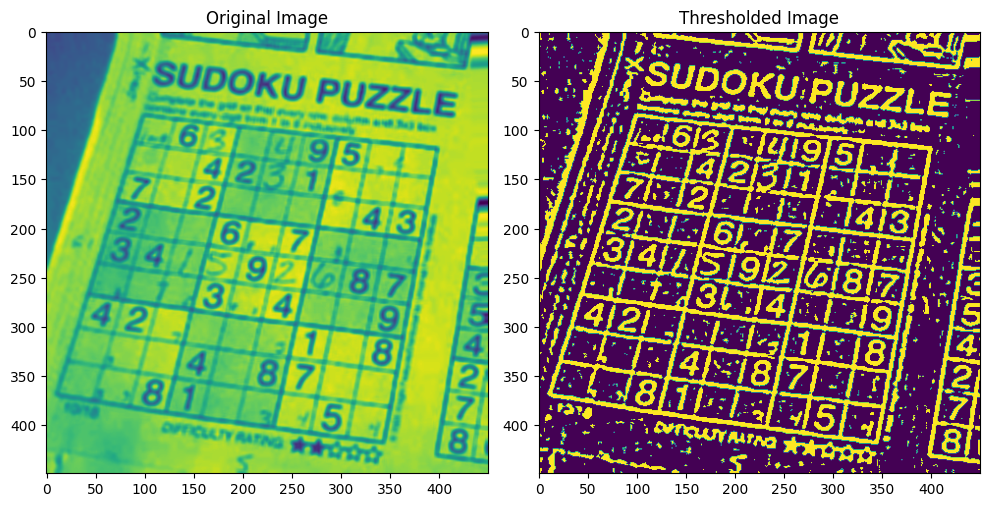

In [308]:
image_copy = image.copy()

threshold = cv2.adaptiveThreshold(image_copy, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_copy)
plt.title('Original Image')

plt.subplot(1, 2 ,2)
plt.imshow(threshold)
plt.title('Thresholded Image')

plt.tight_layout()
plt.show()

# Detect the Contour and its Corners

Now we will detect the contours of the image and extract the largest contour out of all the contours.

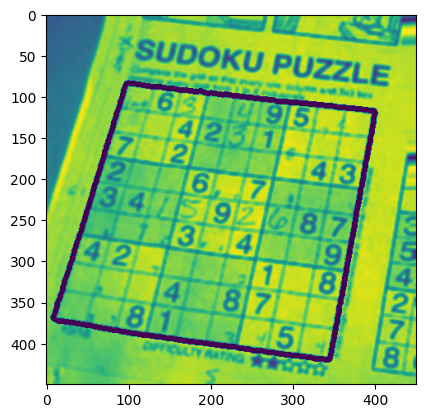

In [309]:
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(image_copy, [largest_contour], -1, (0, 0, 255), 5)
plt.imshow(image_copy)
plt.show()

Now we will get the corners of the largest contour that we got so that we can shift and shear the image making the corners the resized dimension of 500x500 pixels that we want the image size to be.

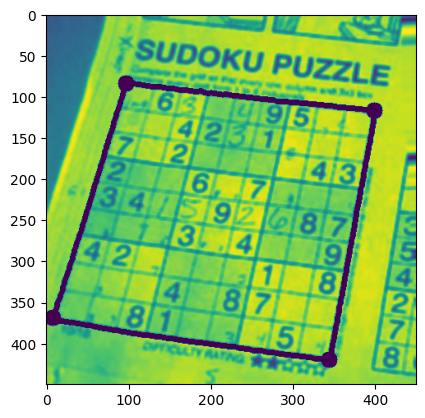

In [310]:
# Approximate the shape of the largest contour to find the corners
epsilon = 0.1 * cv2.arcLength(largest_contour, True)
contour_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
# Draw the corners on the image for visualization
for corner in contour_corners:
    cv2.circle(image_copy, tuple(corner[0]), 10, (0, 0, 255), -1)

# Display the image with the identified corners
plt.imshow(image_copy)
plt.show()

Now we have to define the new placement of the corners which will be a 500x500 pixel image and warp all the points inside the contour that we found accordingly.  

To do that we first have to realize that the corners of the largest contour are mixed so we have to order them in a predefined way, in my case I want to organize them in a clockwise manner and the points will be starting from the top-left corner because in OpenCV, the image's cartesian plane starts from there.  

We will be making two functions:  
1. one function that sorts the corners as stated above.
2. another function that creates corners the same size as the preprocessed image.



In [311]:
def sort_corners(corners:np.array) -> np.array:
    """
    Sorts the corners in clockwise order starting from the top-left corner.
    """
    sorted_corners = np.zeros((4,2), dtype=np.float32)
    corners = corners.reshape((4,2))
    sorted_corners[0] = corners[np.argmin(np.sum(corners, axis=1))]
    sorted_corners[1] = corners[np.argmin(np.diff(corners, axis=1))] 
    sorted_corners[2] = corners[np.argmax(np.sum(corners, axis=1))]
    sorted_corners[3] = corners[np.argmax(np.diff(corners, axis=1))]
    return np.float32(sorted_corners)

def target_corners(image:np.array) -> np.array:
    resize_dim = (image.shape[0], image.shape[1])
    height, width = resize_dim
    target_corners = np.array([[0, 0], [width, 0], [width, height], [0, height]])
    return np.float32(target_corners)

In [312]:

sorted_corners = sort_corners(contour_corners)

targeted_corners = target_corners(image_copy)

# print(f'{sorted_corners = }')
# print(f'{sorted_corners.shape = }')
# print(f'{targeted_corners = }')
# print(f'{targeted_corners.shape = }')

# sorted_corners = sorted_corners.reshape((4,2))
# targeted_corners = targeted_corners.reshape((4,2))

# Warp the Image

Now with the sorted corners and targeted corners we can warp the image so that the largest contour that we found (Sudoku Grid) will be the full sized image.

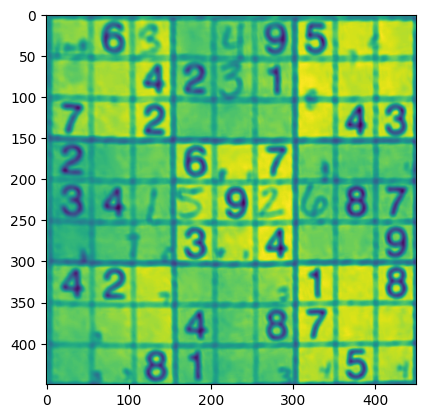

In [313]:
# Calculate the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(sorted_corners, targeted_corners)

# Apply the perspective transformation to warp the identified contour to the 500x500 pixel image
warped_image = cv2.warpPerspective(image, perspective_matrix, image.shape[:2])

# Display the warped image
plt.imshow(warped_image)
plt.show()

# Organize all the preprocessing

Let's make a function to organize all the preprocessing steps that we took until now to get the corners.

In [314]:
def get_contour_corners(image:np.array) -> np.array:
    threshold = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 2)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    contour_corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    return contour_corners


Let's try to replicate all the steps until now with the new function that we created.

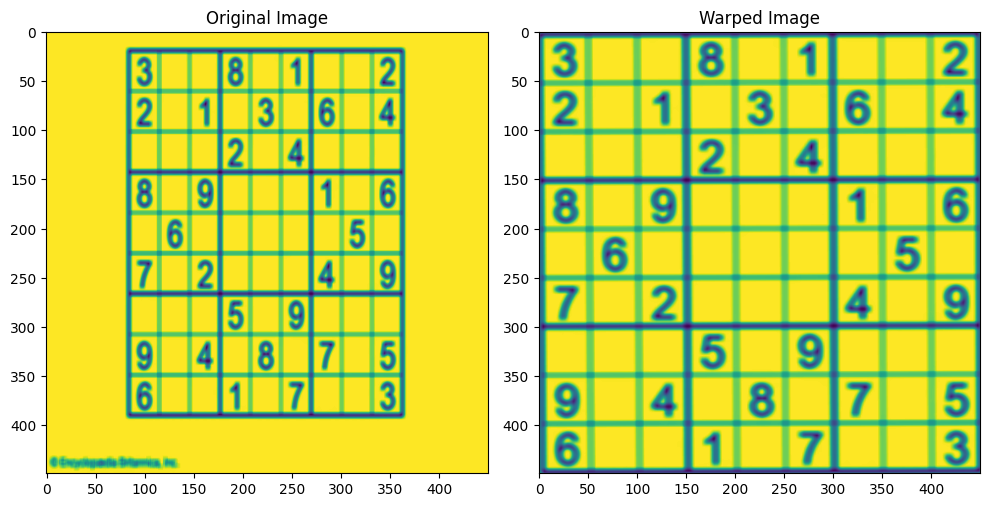

In [315]:
# Real Sudoku Grid
# file_path = './images/toy/2022-us-sudoku-grand-prix-round.png'
# file_path = './images/sudoku-box/_301_1282737.jpeg'
file_path = './images/toy/sudoku-puzzle-games.jpg'

image = cv2.imread(file_path)
grid_image = preprocess_grid(image)
image_copy = grid_image.copy()
contour_corners = get_contour_corners(image_copy)
sorted_corners = sort_corners(contour_corners)
targeted_corners = target_corners(image_copy)
perspective_matrix = cv2.getPerspectiveTransform(sorted_corners, targeted_corners)
warped_image = cv2.warpPerspective(image_copy, perspective_matrix, image_copy.shape[:2])

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image_copy)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(warped_image)
plt.title('Warped Image')

plt.tight_layout()
plt.show()


# Crop boxes

The next step is the crop each of the boxes in the sudoku grid so that we can make predictions of the numbers inside each box. Then we will replicate a numpy array with the shape of a sudoku grid 9x9 and put the predicted digit values inside the replicated numpy array accordingly.

We will make a function to crop each of the boxes in the sudoku grid and plot them to make sure.

In [316]:
def plot_sudoku_boxes(box_images:list) -> None:
    fig, axs = plt.subplots(9, 9, figsize=(3, 3))

    # Iterate over each subplot and image
    for ax, image in zip(axs.ravel(), box_images):
        ax.imshow(image, cmap='gray')  # Display the image in grayscale
        ax.axis('off')  # Turn off axis labels and ticks

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

In [317]:
def divide_into_9x9_boxes(sudoku_grid:np.array) -> list:
    # Get image dimensions
    height, width = sudoku_grid.shape[:2]

    # Calculate box size
    box_height = height // 9
    box_width = width // 9

    # Initialize list to store cropped boxes
    boxes = []

    # Iterate over the rows and columns to extract 9x9 boxes
    for i in range(9):
        for j in range(9):
            # Calculate coordinates for each box
            y_start = i * box_height
            y_end = (i + 1) * box_height
            x_start = j * box_width
            x_end = (j + 1) * box_width

            # Crop box from image
            box = sudoku_grid[y_start:y_end, x_start:x_end]
            boxes.append(box)

    return boxes

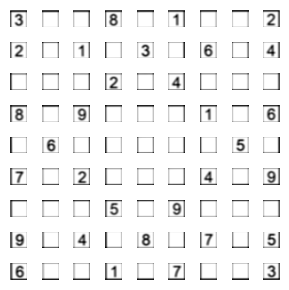

In [318]:
box_images = divide_into_9x9_boxes(warped_image)
plot_sudoku_boxes(box_images)

We can see that we have successfully divided the image into 9x9 boxes. However, we can notice that the box images have a little bit of the edges from the boxes in them and it will certainly introduce some bias to our classification model. To address this we will crop the outer parts of the boxes.

Note: It seems like the predictions work way better without cropping boxes.

In [319]:
def crop_boxes(box_images:list) -> list:
    left = 3
    upper = 3
    right = 47
    lower = 47
    cropped_boxes = []
    for box in box_images:
        # Crop the image
        box = Image.fromarray(box)
        cropped_image = box.crop((left, upper, right, lower))
        cropped_boxes.append(cropped_image)
    return cropped_boxes

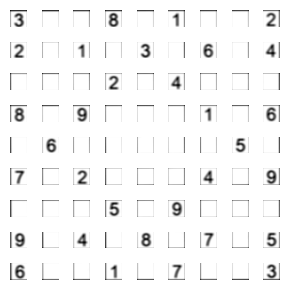

In [320]:
cropped_boxes = crop_boxes(box_images)
plot_sudoku_boxes(cropped_boxes)

# Get digit contours from boxes

In this step we will again make a threshold and get the contours of the digits from each box image.  

Note: I know that we could have just predicted from the box image itself, but it was really hard to find a threshold for the predictions to label between a digit and blank. Reason being that the borders that got cut off into the image were introducing bias (this is the only intuition I could come up with to explain the difficulty in prediction, which was off my only one misprediction). To be on the safe side we are going to get the contours for the digits inside the boxes.

p.s.: This was too hard and out of my skillset. I will come back to this.

In [321]:
# plt.figure(figsize=(10, 10))

# box_image = np.array(cropped_boxes[0]) # already grayscale
# plt.subplot(1, 3, 1)
# plt.imshow(box_image)
# plt.title('Original Image')


# box_threshold = cv2.adaptiveThreshold(box_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# box_threshold = cv2.morphologyEx(box_threshold, cv2.MORPH_OPEN, kernel)
# box_contours, _ = cv2.findContours(box_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# digitcnt = max(box_contours, key=cv2.contourArea)
# mask = np.zeros_like(box_threshold)
# cv2.drawContours(mask, [digitcnt], -1, 255, -1)
# thresh = cv2.bitwise_and(box_threshold, mask)
# # thresh = cv2.bitwise_not(thresh)


# plt.subplot(1, 3 ,2)
# plt.imshow(thresh)
# plt.title('Bounding Box')

# # plt.subplot(1, 3, 3)
# # plt.imshow(thresh)
# # plt.title('Digit')

# plt.tight_layout()
# plt.show()

In [322]:
# model = load_model('./models/cnn_5.h5')

# image = cv2.resize(thresh, (32,32))
# image = preprocess_pixels(image)
# prediction = model.predict(image, verbose=0)
# predicted_probability = prediction.max()
# if predicted_probability < .6:
#     prediction_label = 0
# else:
#     prediction_label = prediction.argmax() + 1
# print(prediction_label)

# Model Predictions

This is just before the final step where we will use the model that we made in digit-recognition.ipynb to make predictions of the numbers inside each box. That is why the first step is to create a function that takes in a list of box images and returns a numpy array of the predictions in the format of a 9x9 sudoku grid.

In [323]:
def predict_sudoku_grid(box_images:list, model:tf.keras.Model, verbose:int=0) -> np.array:
    
    sudoku_grid = np.zeros(81)

    for index, box in enumerate(box_images):
        box = np.array(box)
        box = cv2.resize(box, (32,32))
        box = preprocess_pixels(box)

        prediction = model.predict(box, verbose=0)
        if verbose == 1:
            print(f'Box {index+1}: {prediction.round(3)}')
        predicted_probability = prediction.max()
        if predicted_probability < .6:
            prediction_label = 0
        else:
            prediction_label = prediction.argmax() + 1
            
        sudoku_grid[index] = prediction_label
    return sudoku_grid.reshape((9,9))

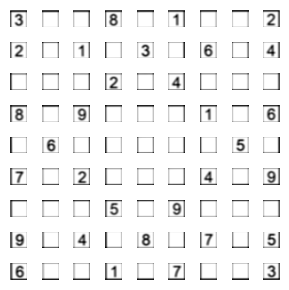

[[3. 0. 0. 8. 0. 1. 0. 0. 2.]
 [2. 0. 1. 0. 3. 0. 6. 0. 4.]
 [0. 0. 0. 2. 0. 4. 0. 0. 0.]
 [8. 0. 9. 0. 0. 0. 1. 0. 6.]
 [0. 6. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 2. 0. 0. 0. 4. 0. 9.]
 [0. 0. 0. 5. 0. 9. 0. 0. 0.]
 [9. 0. 4. 0. 8. 0. 7. 0. 5.]
 [6. 0. 0. 1. 0. 7. 0. 0. 3.]]


In [324]:
model = load_model('./models/cnn_6.h5')

plot_sudoku_boxes(box_images)
sudoku_grid = predict_sudoku_grid(box_images, model)
print(sudoku_grid)

# Solve Sudoku

In [327]:
def possible(y, x, n, sudoku_grid):
    for i in range(9):
        if sudoku_grid[i][x] == n:
            return False
    for i in range(9):
        if sudoku_grid[y][i] == n:
            return False
    x0 = (x//3) * 3
    y0 = (y//3) * 3
    for i in range(3):
        for j in range(3):
            if sudoku_grid[y0+i][x0+j] == n:
                return False
    return True

def solve_sudoku(sudoku_grid):
    for y in range(9):
        for x in range(9):
            if sudoku_grid[y][x] == 0:
                for n in range(1, 10):
                    if possible(y, x, n, sudoku_grid):
                        sudoku_grid[y][x] = n
                        solve_sudoku(sudoku_grid)
                        sudoku_grid[y][x] = 0
                return
    print(sudoku_grid)
    input('Press Enter to check for anymore solutions...')

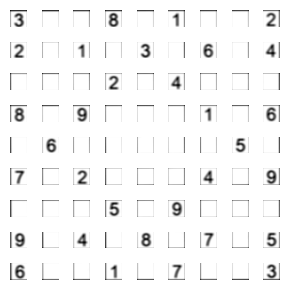

[[3. 4. 6. 8. 9. 1. 5. 7. 2.]
 [2. 8. 1. 7. 3. 5. 6. 9. 4.]
 [7. 9. 5. 2. 6. 4. 3. 8. 1.]
 [8. 7. 9. 4. 5. 3. 1. 2. 6.]
 [4. 6. 3. 9. 1. 2. 8. 5. 7.]
 [5. 1. 2. 6. 7. 8. 4. 3. 9.]
 [1. 3. 7. 5. 4. 9. 2. 6. 8.]
 [9. 2. 4. 3. 8. 6. 7. 1. 5.]
 [6. 5. 8. 1. 2. 7. 9. 4. 3.]]
[[3. 4. 6. 8. 9. 1. 5. 7. 2.]
 [2. 8. 1. 7. 3. 5. 6. 9. 4.]
 [7. 9. 5. 2. 6. 4. 3. 8. 1.]
 [8. 7. 9. 4. 5. 3. 1. 2. 6.]
 [4. 6. 3. 9. 1. 2. 8. 5. 7.]
 [5. 1. 2. 6. 7. 8. 4. 3. 9.]
 [1. 3. 7. 5. 4. 9. 2. 6. 8.]
 [9. 2. 4. 3. 8. 6. 7. 1. 5.]
 [6. 5. 8. 1. 2. 7. 9. 4. 3.]]


In [328]:
plot_sudoku_boxes(cropped_boxes)
board = sudoku_grid
solve_sudoku(board)
print(board)